# CHSH Quantum game

In order to run this program in local you must have the environment configured

Importing libraries

In [1]:

# Utility libraries
import random
import csv
import os
from math import pi as π
from tkinter import Tk, filedialog
from datetime import datetime

# Libraries to the quantum computing framework
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile


Add your quantum IBM token to run jobs

In [2]:
Service = QiskitRuntimeService(channel="ibm_quantum",token="57c7ea0543f8efa5bbe36ea031aa9ac59cd1d12c7d025a73c1980193de8b6b6d55ab8dc0e063ab2ebc77ad4a1f608493591830225665f15648ad7ebc309b2d1a")

Backends

In [3]:
# Backends
backend_osk = Service.least_busy(simulator=False, operational=True) # IBM Quantum backend
sampler_osk = SamplerV2(backend_osk) # Simulator backend

Esta parte crea el esquema general del circuito, ya que no cambia mucho su estructura entre medidas, solo los angulos en la compuerta Ry

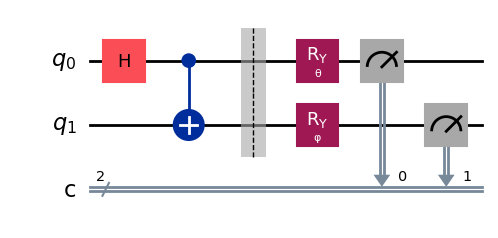

In [4]:
# Parameters of the quantum circuit
θ=Parameter('θ')
φ=Parameter('φ')

qc1 = QuantumCircuit(2, 2)
qc1.h(0)
qc1.cx(0, 1)
qc1.barrier()

qc1.ry(θ, 0)
qc1.ry(φ, 1)

qc1.measure(0, 0)
qc1.measure(1, 1)

qcCompiled = transpile(qc1, backend=backend_osk)
qc1.draw('mpl')

Aqui obtenemos los valores de entrada aleatoria X y Y, ademas de los angulos necesarios para cada una de los circuitos

In [5]:
quantum_circuits = []
for _ in range(1000):
  X,Y = random.randint(0,1), random.randint(0,1)

  qc1 = QuantumCircuit(2, 2)

  qc1.h(0)
  qc1.cx(0, 1)
  qc1.barrier()

  # Alice's action
  if X == 0:
    θ1=0
  else:
    θ1=-π / 2
    
  # Bob's action
  if Y == 0:
    φ1=-π / 4
  else:
    φ1=π / 4
  quantum_circuits.append([X,Y,θ1,φ1])

En esta parte se crea una lista asignando los valores de los angulos a el circuito cuantico

In [6]:
Crc = []
angles = [[row[2],row[3]] for row in quantum_circuits]
for i in range(1000):
    Crc.append((qcCompiled, angles[i], 1))

Mandamos el trabajo a un computador cuantico, ademas creamos un archivo csv para guardar los datos de los X, Y, los angulos y la fecha en que fue hecho el trabajo

In [7]:
job_osk = sampler_osk.run(Crc)
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job_osk.job_id()}")
f_h = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

file_name = f"{job_osk.job_id()}.csv"

# Save X Y θ φ
with open(file_name, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["index","X", "Y","θ","φ","Date and time"])  # headers
    for i,(x, y, θ, φ) in enumerate(quantum_circuits):
        writer.writerow([i, x, y, θ, φ, f_h])

>>> Job ID: d0thqmevx7bg0081ckv0


Este codigo solo lo usamos para leer los archivos csv, ademas extrae del nombre el id del trabajo para poder acceder al mismo

Si se hace en coolab de google hay que buscar otra forma de abrir los archivos

Preferible trabajarlo en un entorno local con todas las extensiones necesarias

In [5]:
# Open a file dialog to select the CSV file
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)
file_name = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])

# Extract the job ID from the file name
job_id = os.path.splitext(os.path.basename(file_name))[0]

# Read the CSV file and extract the data
Val = []
with open(file_name, newline="") as file:
    reader = csv.DictReader(file)
    
    for row in reader:
        x = int(row["X"])
        y = int(row["Y"])
        θ2 = float(row["θ"]) 
        φ2 = float(row["φ"])
        f_h = row["Date and time"]
        Val.append((x, y, θ2, φ2,f_h))
job_osk = Service.job(job_id)
f_h=Val[0][4]
print(f">>> Job ID: {job_id}")

>>> Job ID: d0thqmevx7bg0081ckv0


Esta parte Extrae los valores de respuesta de Alice y Bob y evalua la condicion para ganar el juego

In [6]:
result_osk=job_osk.result()

Points = 0

for i in range(1000):
  counts_qc1_osk = result_osk[i].data.c.get_counts()
  bits = list(counts_qc1_osk.keys())[0]
  A, B = bits[0], bits[1]

  X = Val[i][0]
  Y = Val[i][1]

  if (A != B) == (X & Y):
    Points += 1
print("Won games percentage", 100 * Points / 1000)
print("Work made on", f_h)

Won games percentage 45.5
Work made on 2025_05_26_20_56_38
